In [26]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from nilearn.image import new_img_like

import pandas as pd
import nibabel as nib
import seaborn as sns
from nilearn import plotting
from nilearn import image
from nilearn import masking
import matplotlib.colors
from rsatoolbox.inference import eval_fixed
from rsatoolbox.model import ModelFixed
from rsatoolbox.rdm import RDMs
from rsatoolbox.util.searchlight import get_volume_searchlight, get_searchlight_RDMs, evaluate_models_searchlight
import rsatoolbox
from scipy.spatial.distance import pdist, squareform

In [186]:

def upper_tri(RDM):
    """upper_tri returns the upper triangular index of an RDM

    Args:
        RDM 2Darray: squareform RDM

    Returns:
        1D array: upper triangular vector of the RDM
    """
    # returns the upper triangle
    m = RDM.shape[0]
    r, c = np.triu_indices(m, 1)
    return RDM[r, c]


def RDMcolormapObject(direction=1):
    """
    Returns a matplotlib color map object for RSA and brain plotting
    """
    if direction == 0:
        cs = ['yellow', 'red', 'gray', 'turquoise', 'blue']
    elif direction == 1:
        cs = ['blue', 'turquoise', 'gray', 'red', 'yellow']
    else:
        raise ValueError('Direction needs to be 0 or 1')
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", cs)
    return cmap
def load_searchlight(singletrial_dir, sub, ses, run):
    """Load single trial average beta estimates within session

    Args:
        singletrial_dir (str): directory containing single trial beta estimates
        sub (str): BIDS subject id
        ses (str): BIDS session id
        run (str): BIDS run id

    Returns:
        np.array: numpy array of shape num_samples num_labels
    """
    from nilearn import datasets
    from nilearn import masking
    get_shape = glob.glob(os.path.join(
            singletrial_dir, sub, f'{sub}_{ses}_run-01_runtype-*_event-stimulus_trial-*_cuetype-high_stimintensity-high.nii.gz'))
    tmp_img = nib.load(get_shape[0])
    x, y, z = tmp_img.get_fdata().shape
    # arr = np.empty((0, get_shape_data.shape[0]), int)
    arr = np.empty((0, tmp_img.get_fdata().ravel().shape[0]), int)
    # Stimulus trials for the given runtype.
    masklist = []
    for runtype in ['pain', 'cognitive', 'vicarious']:
        run = '*'
        stim_H_cue_H = sorted(glob.glob(os.path.join(
            singletrial_dir, sub, f'{sub}_{ses}_{run}_runtype-{runtype}_event-stimulus_trial-*_cuetype-high_stimintensity-high.nii.gz')))
        stim_M_cue_H = sorted(glob.glob(os.path.join(
            singletrial_dir, sub, f'{sub}_{ses}_{run}_runtype-{runtype}_event-stimulus_trial-*_cuetype-high_stimintensity-med.nii.gz')))
        stim_L_cue_H = sorted(glob.glob(os.path.join( 
            singletrial_dir, sub, f'{sub}_{ses}_{run}_runtype-{runtype}_event-stimulus_trial-*_cuetype-high_stimintensity-low.nii.gz')))
        stim_H_cue_L = sorted(glob.glob(os.path.join(
            singletrial_dir, sub, f'{sub}_{ses}_{run}_runtype-{runtype}_event-stimulus_trial-*_cuetype-low_stimintensity-high.nii.gz')))
        stim_M_cue_L = sorted(glob.glob(os.path.join(
            singletrial_dir, sub, f'{sub}_{ses}_{run}_runtype-{runtype}_event-stimulus_trial-*_cuetype-low_stimintensity-med.nii.gz')))
        stim_L_cue_L = sorted(glob.glob(os.path.join(
            singletrial_dir, sub, f'{sub}_{ses}_{run}_runtype-{runtype}_event-stimulus_trial-*_cuetype-low_stimintensity-low.nii.gz')))
        stim_flist = []
        [stim_flist.extend(l) for l in (stim_H_cue_H, stim_M_cue_H,
                           stim_L_cue_H, stim_H_cue_L, stim_M_cue_L, stim_L_cue_L)]

        stim_H_cue_H_mean = image.mean_img(
            image.concat_imgs(stim_H_cue_H)).get_fdata().ravel()
        stim_M_cue_H_mean = image.mean_img(
            image.concat_imgs(stim_M_cue_H)).get_fdata().ravel()
        stim_L_cue_H_mean = image.mean_img(
            image.concat_imgs(stim_L_cue_H)).get_fdata().ravel()
        stim_H_cue_L_mean = image.mean_img(
            image.concat_imgs(stim_H_cue_L)).get_fdata().ravel()
        stim_M_cue_L_mean = image.mean_img(
            image.concat_imgs(stim_M_cue_L)).get_fdata().ravel()
        stim_L_cue_L_mean = image.mean_img(
            image.concat_imgs(stim_L_cue_L)).get_fdata().ravel()
        runwise_array = np.vstack((stim_H_cue_H_mean, stim_M_cue_H_mean, stim_L_cue_H_mean,
                                    stim_H_cue_L_mean, stim_M_cue_L_mean, stim_L_cue_L_mean))
        arr = np.concatenate((arr, runwise_array), axis=0)
        # mask = ~np.isnan(image.load_img(image.concat_imgs([stim_H_cue_H, stim_M_cue_H, stim_L_cue_H,
                                    # stim_H_cue_L, stim_M_cue_L, stim_L_cue_L])).get_fdata())
        masklist.extend([stim_H_cue_H, stim_M_cue_H, stim_L_cue_H,
                                stim_H_cue_L, stim_M_cue_L, stim_L_cue_L])
        # image.concat_imgs([mask, stim_H_cue_H, stim_M_cue_H, stim_L_cue_H,
        #                         stim_H_cue_L, stim_M_cue_L, stim_L_cue_L])
    print(masklist)
    print(len(masklist))
    mask_img = masking.compute_brain_mask(masklist, threshold=.1)
    print(mask_img.get_fdata().shape)
    print(np.sum(~np.isnan(mask_img.get_fdata())))
    return arr, mask_img, x,y,z


def load_expect(data_dir, sub, ses ):
    tasklist = ['pain', 'vicarious', 'cognitive']
    seswise_expect = pd.DataFrame()
    for task in tasklist:
        runwise_df = pd.DataFrame()
        flist = glob.glob(os.path.join(data_dir, sub, ses, f"{sub}_{ses}_*{task}_beh.csv"))
        for f in flist: 
            df = pd.read_csv(f)
            df['trial'] = df.index
            df['trial_order'] = df.groupby('param_cond_type', as_index=False)['param_cond_type'].cumcount()
            runwise_df = pd.concat([runwise_df, df])
        # convert run number
        runwise_df['run_order'] = runwise_df['param_run_num'].gt(np.mean(runwise_df['param_run_num']), 0)*1
        seswise_02expect = runwise_df.pivot_table(index=['param_cue_type','param_stimulus_type'], columns=['trial_order', 'run_order'],
                            values=['event02_expect_angle']) #, aggfunc='first')
        seswise_02expect.columns  = [col[0]+'_'+str(col[1]) for col in seswise_02expect.columns.values]
        seswise_02expect = seswise_02expect.reset_index()
        seswise_02expect["condition"] = task + '_' + seswise_02expect['param_cue_type'].astype(str) + '_' + seswise_02expect["param_stimulus_type"]

        # reorder values
        seswise_02expect['stim_order'] = seswise_02expect['param_stimulus_type'].map({'high_cue':0, 'low_cue':1, 'high_stim':0, 'med_stim':1, 'low_stim':2})  
        seswise_02expect['cue_order'] = seswise_02expect['param_cue_type'].map({'high_cue':0, 'low_cue':1, 'high_stim':0, 'med_stim':1, 'low_stim':2})    
        ses_expect = seswise_02expect.sort_values(['cue_order','stim_order'])
        seswise_expect = pd.concat([seswise_expect, ses_expect])
    return(seswise_expect.reset_index(drop = True))

In [8]:
# parameters
nifti_dir = '/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/singletrial/'
modelRDM_dir = '/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/rsa/modelrdm'

In [187]:
fname = "/Users/h/Dropbox/projects_dropbox/social_influence_analysis/resources/sub-0127/sub-0127_ses-01_rsadata.pkl"
obj = pd.read_pickle(fname)
# %%
sub = 'sub-0078'
ses = 'ses-01'
run = 'run-02'
# set this path to wherever you saved the folder containing the img-files
nifti_dir = '/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/singletrial/'
flist = glob.glob(os.path.join(nifti_dir, sub, f"{sub}_{ses}_{run}_*event-stimulus_trial-*.nii.gz"))
arr, mask, x,y,z = load_searchlight(nifti_dir, sub, ses, run)
# tmp_img = nib.load(flist[0]) # load one image to get the dimensions and make the mask
# mask_data = ~np.isnan(mask) # we infer the mask by looking at non-nan voxels
# x, y, z = tmp_img.get_fdata().shape
# tmp_mask = masking.compute_brain_mask(tmp_img)
# data = np.zeros((len(flist), x, y, z)) # loop over all images
# for x, im in enumerate(flist):
#     data[x] = nib.load(im).get_fdata()

[['/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/singletrial/sub-0078/sub-0078_ses-01_run-01_runtype-pain_event-stimulus_trial-005_cuetype-high_stimintensity-high.nii.gz', '/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/singletrial/sub-0078/sub-0078_ses-01_run-01_runtype-pain_event-stimulus_trial-008_cuetype-high_stimintensity-high.nii.gz', '/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/singletrial/sub-0078/sub-0078_ses-01_run-05_runtype-pain_event-stimulus_trial-006_cuetype-high_stimintensity-high.nii.gz', '/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/singletrial/sub-0078/sub-0078_ses-01_run-05_runtype-pain_event-stimulus_trial-011_cuetype-high_stimintensity-high.nii.gz'], ['/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/singletrial/sub-0078/sub-0078_ses-01_run-01_runtype-pain_event-stimulus_trial-004_cuetype-high_stimintensity-med.nii.gz', '/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/singletrial/sub-0078/sub-0078_ses-01_run-01_runtype-pain_e

In [265]:
K = arr*mask.get_fdata().ravel()
K.shape

(18, 458294)

In [266]:
np.sum(~np.isnan(K))

8249292

In [209]:
test = mask.get_fdata().ravel() * arr

In [243]:
print(f"----test----")
print(f"shape: {test.shape}")
print(f"any NaNs?: {np.sum(np.isnan(test))}")

print(f"----mask----")
print(f"shape: {mask.get_fdata().shape}")
print(f"any NaNs?: {np.sum(np.isnan(mask.get_fdata()))}")

----test----
shape: (18, 458294)
any NaNs?: 0
----mask----
shape: (73, 86, 73)
any NaNs?: 0


In [269]:
# %% Step 1: Get searchlight centers and neighbors ____________________________________________
centers, neighbors = get_volume_searchlight(mask.get_fdata(), radius=12, threshold=0.5)

# %% Step 2: Get an RDM for each voxel¶
image_value = np.arange(arr.shape[0])
data_2d = np.nan_to_num(arr)

SL_RDM1 = get_searchlight_RDMs(arr, centers, neighbors, image_value, method='correlation') # Get RDMs
# SL_RDM2 = get_searchlight_RDMs(mask.get_fdata().ravel() * arr, centers, neighbors, image_value, method='correlation') # Get RDMs
# SL_RDM3 = get_searchlight_RDMs(np.nan_to_num(arr), centers, neighbors, image_value, method='correlation') # Get RDMs

Found 82695 searchlights



























































































































































































































































































































































































































































































































Calculating RDMs...: 100%|██████████| 100/100 [08:34<00:00,  5.15s/it]










































































































































































































































































































































































































































In [264]:
print(f"voxel indices: {SL_RDM.rdm_descriptors['voxel_index'].shape}")
print(f"number of nans?: {np.sum(np.isnan(SL_RDM.dissimilarities))}")
print(f"number of nan in mask? {np.sum(np.isnan(mask.get_fdata()))}")

voxel indices: (458294,)
number of nans?: 51544095
number of nan in mask? 0


In [268]:
centers.shape

(458294,)

In [267]:
SL_RDM.dissimilarities.shape


(458294, 153)

In [205]:
save_dir = '/Users/h/Dropbox/projects_dropbox/social_influence_analysis/analysis/fmri/nilearn/rsa/modelrdm'

In [271]:
# %% Step 3: Load animal model and evaluate
# model_grid ________________________________________________________________________________
modelRDM_dir = save_dir
cue_RDM = np.load(os.path.join(modelRDM_dir, 'model-cue.npy'))
stim_RDM = np.load(os.path.join(modelRDM_dir, 'model-stim.npy'))
grid_RDM = np.load(os.path.join(modelRDM_dir, 'model-grid.npy'))
orthogonal_RDM = np.load(os.path.join(modelRDM_dir, 'model-orthogonal.npy'))
rotationgrid_RDM = np.load(os.path.join(modelRDM_dir, 'model-rotationgrid.npy'))
parallel_RDM = np.load(os.path.join(modelRDM_dir, 'model-parallel.npy'))
diagonal_RDM = np.load(os.path.join(modelRDM_dir, 'model-diagonal.npy'))

# %%
X = [rsatoolbox.model.ModelWeighted('cue', upper_tri(cue_RDM)),
     rsatoolbox.model.ModelWeighted('stim', upper_tri(stim_RDM)),
     rsatoolbox.model.ModelWeighted('grid', upper_tri(grid_RDM)),
     rsatoolbox.model.ModelWeighted('orthogonal', upper_tri(orthogonal_RDM)),
     rsatoolbox.model.ModelWeighted('rotationgrid', upper_tri(rotationgrid_RDM)),
     rsatoolbox.model.ModelWeighted('parallel', upper_tri(parallel_RDM)),
     rsatoolbox.model.ModelWeighted('diagonal', upper_tri(diagonal_RDM))]
model_names = ['cue', 'stim', 'grid', 'orthogonal', 'rotationgrid',  'parallel', 'diagonal']   
eval_results = evaluate_models_searchlight(SL_RDM1, X, eval_fixed, method='spearman', n_jobs=3)
# TODO: sklearn linear regression and dot fit. dot coef. fit intercept
# SL_RDM1 and X. zscore and rank. standardized rank regression


KeyboardInterrupt: 

In [275]:
cue_RDM

array([[0., 0., 0., 2., 2., 2., 0., 0., 0., 2., 2., 2., 0., 0., 0., 2.,
        2., 2.],
       [0., 0., 0., 2., 2., 2., 0., 0., 0., 2., 2., 2., 0., 0., 0., 2.,
        2., 2.],
       [0., 0., 0., 2., 2., 2., 0., 0., 0., 2., 2., 2., 0., 0., 0., 2.,
        2., 2.],
       [2., 2., 2., 0., 0., 0., 2., 2., 2., 0., 0., 0., 2., 2., 2., 0.,
        0., 0.],
       [2., 2., 2., 0., 0., 0., 2., 2., 2., 0., 0., 0., 2., 2., 2., 0.,
        0., 0.],
       [2., 2., 2., 0., 0., 0., 2., 2., 2., 0., 0., 0., 2., 2., 2., 0.,
        0., 0.],
       [0., 0., 0., 2., 2., 2., 0., 0., 0., 2., 2., 2., 0., 0., 0., 2.,
        2., 2.],
       [0., 0., 0., 2., 2., 2., 0., 0., 0., 2., 2., 2., 0., 0., 0., 2.,
        2., 2.],
       [0., 0., 0., 2., 2., 2., 0., 0., 0., 2., 2., 2., 0., 0., 0., 2.,
        2., 2.],
       [2., 2., 2., 0., 0., 0., 2., 2., 2., 0., 0., 0., 2., 2., 2., 0.,
        0., 0.],
       [2., 2., 2., 0., 0., 0., 2., 2., 2., 0., 0., 0., 2., 2., 2., 0.,
        0., 0.],
       [2., 2., 2., 0

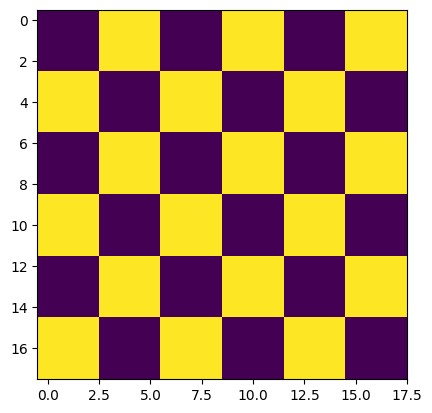

In [276]:
plt.imshow(squareform(pdist(cue_RDM)))

/var/folders/w8/z3vy42z17hq5gc9r_5hzsgxw0000gn/T/ipykernel_71296/2364737869.py:4: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.iloc[:,i] = e.evaluations[0]
/var/folders/w8/z3vy42z17hq5gc9r_5hzsgxw0000gn/T/ipykernel_71296/2364737869.py:14: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.T[model_i].tolist())


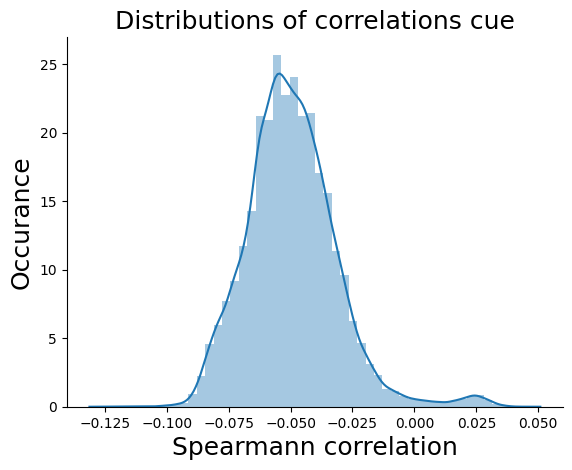

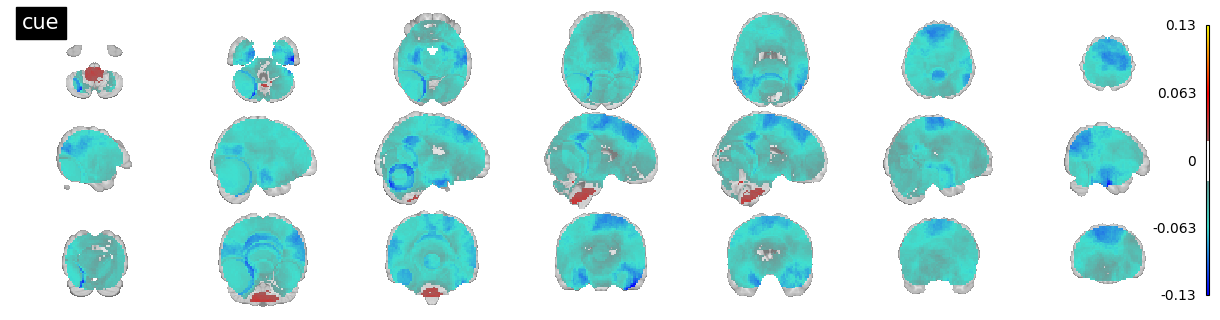

/var/folders/w8/z3vy42z17hq5gc9r_5hzsgxw0000gn/T/ipykernel_71296/2364737869.py:14: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.T[model_i].tolist())


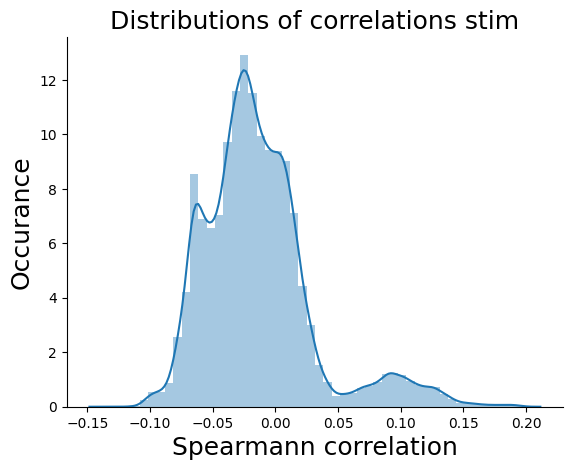

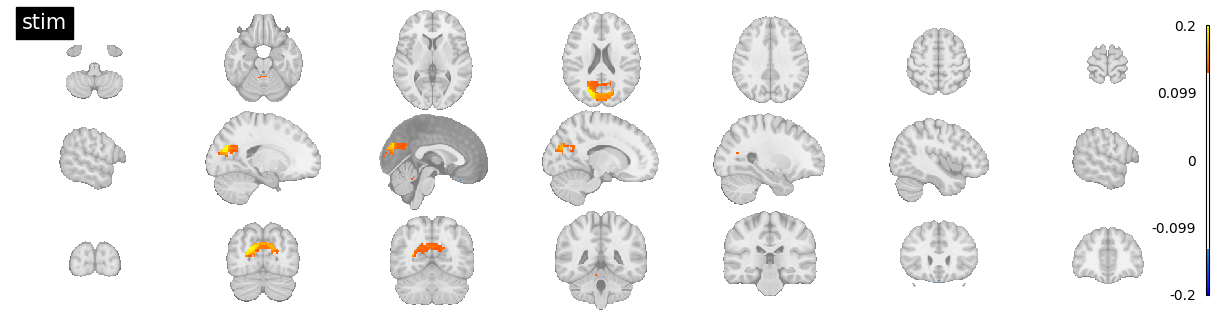

/var/folders/w8/z3vy42z17hq5gc9r_5hzsgxw0000gn/T/ipykernel_71296/2364737869.py:14: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.T[model_i].tolist())


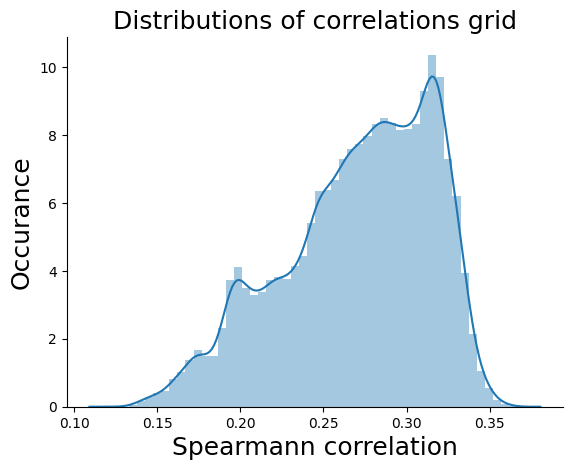

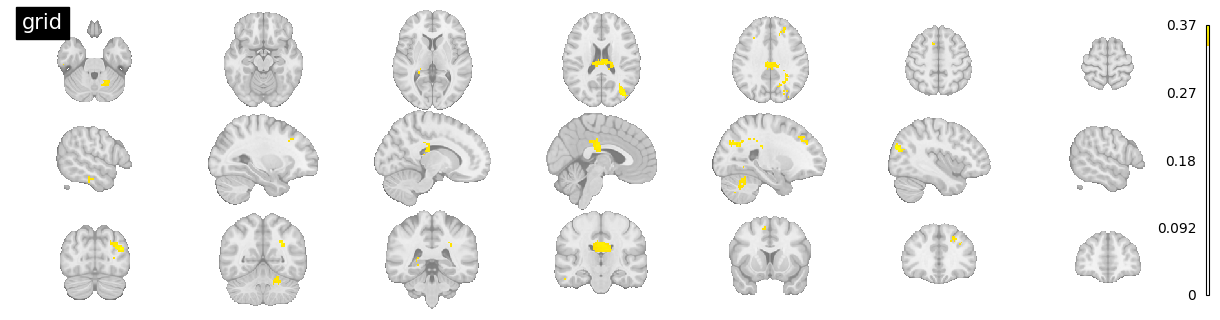

/var/folders/w8/z3vy42z17hq5gc9r_5hzsgxw0000gn/T/ipykernel_71296/2364737869.py:14: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.T[model_i].tolist())


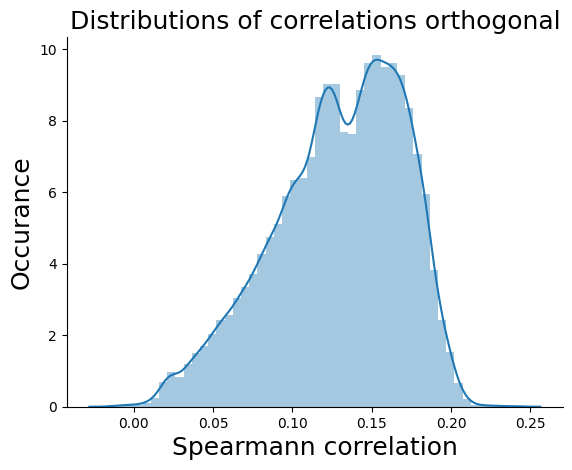

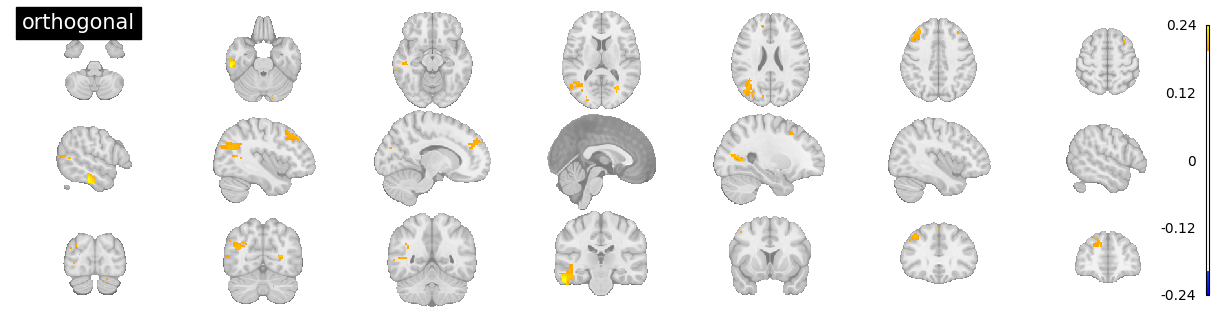

/var/folders/w8/z3vy42z17hq5gc9r_5hzsgxw0000gn/T/ipykernel_71296/2364737869.py:14: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.T[model_i].tolist())


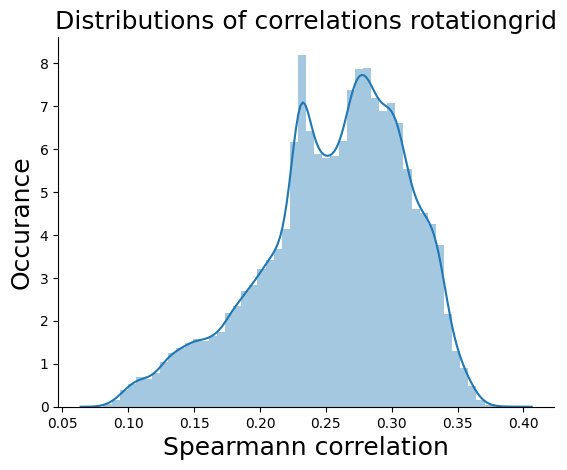

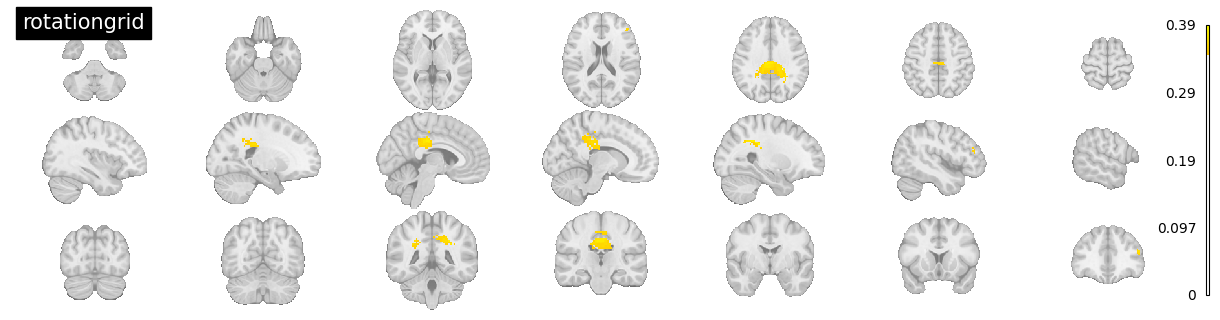

/var/folders/w8/z3vy42z17hq5gc9r_5hzsgxw0000gn/T/ipykernel_71296/2364737869.py:14: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.T[model_i].tolist())


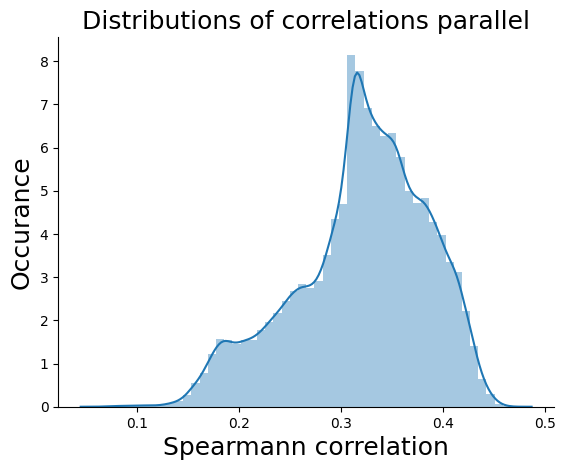

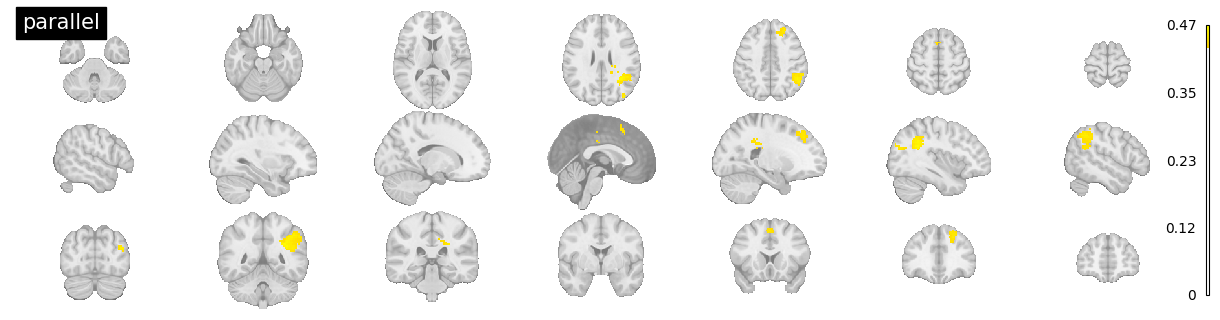

/var/folders/w8/z3vy42z17hq5gc9r_5hzsgxw0000gn/T/ipykernel_71296/2364737869.py:14: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.T[model_i].tolist())


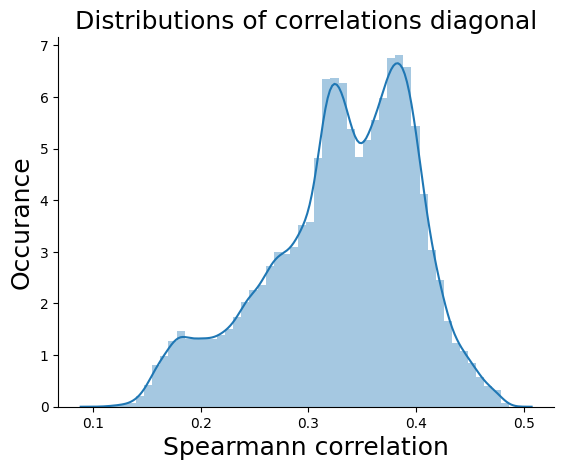

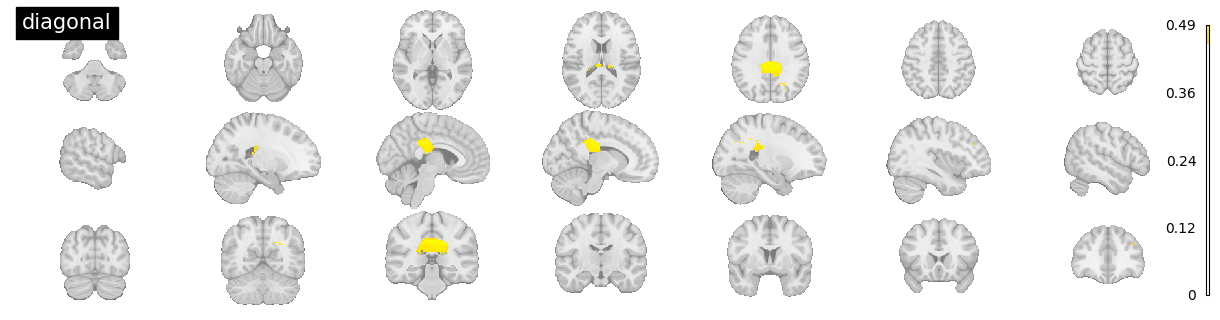

In [274]:

# %%
df = pd.DataFrame(index=range(len(X)), columns=range(len(eval_results)))
for i, e in enumerate(eval_results):
    df.iloc[:,i] = e.evaluations[0]

# %% Create an 3D array, with the size of mask, and

for model_i, model_name in enumerate(model_names):
    x, y, z = mask.shape
    RDM_brain = np.zeros([x*y*z])
    RDM_brain[list(SL_RDM1.rdm_descriptors['voxel_index'])] = df.T[model_i].tolist()
    RDM_brain = RDM_brain.reshape([x, y, z])

    sns.distplot(df.T[model_i].tolist())
    plt.title(f'Distributions of correlations {model_name}', size=18)
    plt.ylabel('Occurance', size=18)
    plt.xlabel('Spearman correlation', size=18)
    sns.despine()
    plt.show()

    # lets plot the voxels above the 99th percentile
    threshold = np.percentile(df.T[model_i].tolist(), 99)
    plot_img = new_img_like(mask, RDM_brain)

    cmap = RDMcolormapObject()

    coords = range(-20, 40, 5)
    fig = plt.figure(figsize=(12, 3))

    display = plotting.plot_stat_map(
            plot_img, colorbar=True, threshold=threshold,
            display_mode='mosaic', draw_cross=False, figure=fig,
            title=f'{model_name}', cmap=cmap,
            black_bg=False, annotate=False) #cut_coords=coords,
    plt.show()

In [279]:
# eval_results = evaluate_models_searchlight(SL_RDM1, X, eval_fixed, method='spearman', n_jobs=3)
results_1 = rsatoolbox.inference.eval_fixed(X, SL_RDM1, method='corr')
rsatoolbox.vis.plot_model_comparison(results_1)

: 

: 